# **RDS Project**

# Import

In [ ]:
# Install DataSynthesizer
!pip install DataSynthesizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 5.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from DataSynthesizer.lib.utils import pairwise_attributes_mutual_information, mutual_information
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.adversarial import AdversarialFairnessClassifier
from fairlearn.metrics import MetricFrame
import fairlearn.datasets as fdata
from fairlearn.metrics import (demographic_parity_difference, demographic_parity_ratio, 
                               selection_rate_difference, false_negative_rate_difference, 
                               false_positive_rate_difference, equalized_odds_ratio,
                               false_negative_rate, false_positive_rate)

# Data Preparation

In [ ]:
!pip install -U -q PyDrive==1.3.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# https://drive.google.com/file/d/1qtMgp8V3QeYZvVXBfLYxU9ky5_AH5dxT/view?usp=sharing
fileid_compas = '1qtMgp8V3QeYZvVXBfLYxU9ky5_AH5dxT'    
sensitive_data_file = 'Job_Placement_Data.csv'

downloaded = drive.CreateFile({'id':fileid_compas}) 
downloaded.GetContentFile(sensitive_data_file)

In [ ]:
# Data preview 
data = pd.read_csv(sensitive_data_file)
data.head()

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


## Input and Output

In [ ]:
# Data Information 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               215 non-null    object 
 1   ssc_percentage       215 non-null    float64
 2   ssc_board            215 non-null    object 
 3   hsc_percentage       215 non-null    float64
 4   hsc_board            215 non-null    object 
 5   hsc_subject          215 non-null    object 
 6   degree_percentage    215 non-null    float64
 7   undergrad_degree     215 non-null    object 
 8   work_experience      215 non-null    object 
 9   emp_test_percentage  215 non-null    float64
 10  specialisation       215 non-null    object 
 11  mba_percent          215 non-null    float64
 12  status               215 non-null    object 
dtypes: float64(5), object(8)
memory usage: 22.0+ KB


**Data Information**
* `gender` : Gender of the candidate
* `ssc_percentage` : Senior secondary exams percentage (10th Grade)
* `ssc_board` : Board of education for ssc exams
* `hsc_percentage` : Higher secondary exams percentage (12th Grade)
* `hsc_borad` : Board of education for hsc exams
* `hsc_subject` : Subject of study for hsc
* `degree_percentage` : Percentage of marks in undergrad degree
* `undergrad_degree` : Undergrad degree majors
* `work_experience` : Past work experience
* `emp_test_percentage` : Aptitude test percentage
* `specialization` : Postgrad degree majors - (MBA specialization)
* `mba_percent` : Percentage of marks in MBA degree
* `status (TARGET)` : Status of placement. Placed / Not Placed



In [ ]:
#null values count
data.isnull().sum()

gender                 0
ssc_percentage         0
ssc_board              0
hsc_percentage         0
hsc_board              0
hsc_subject            0
degree_percentage      0
undergrad_degree       0
work_experience        0
emp_test_percentage    0
specialisation         0
mba_percent            0
status                 0
dtype: int64

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ssc_percentage,215.0,67.303395,10.827205,40.89,60.600,67.0,75.700,89.40
hsc_percentage,215.0,66.333163,10.897509,37.00,60.900,65.0,73.000,97.70
degree_percentage,215.0,66.370186,7.358743,50.00,61.000,66.0,72.000,91.00
emp_test_percentage,215.0,72.100558,13.275956,50.00,60.000,71.0,83.500,98.00
mba_percent,215.0,62.278186,5.833385,51.21,57.945,62.0,66.255,77.89


**Correlation between variables**

In [ ]:
# numeric variable versus categorical variable
data_numeric = data[['ssc_percentage','hsc_percentage','degree_percentage','emp_test_percentage','mba_percent']]
data_categorical = data[['gender','ssc_board','hsc_board','hsc_subject','undergrad_degree','work_experience','specialisation','status']]

[Text(0.5, 1.0, 'categorical mutual information')]

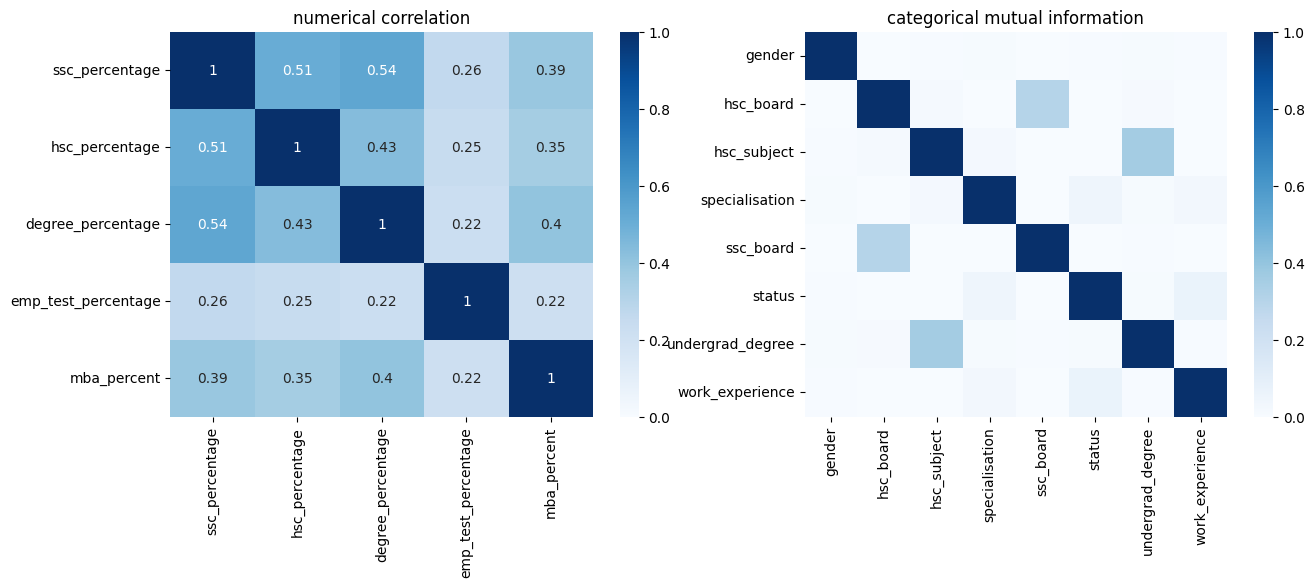

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=100)
sns.heatmap(data_numeric.corr(),ax=axes[0],cmap='Blues',vmin=0,vmax=1,annot = True).set(title='numerical correlation')
sns.heatmap(pairwise_attributes_mutual_information(data_categorical), ax=axes[1],cmap='Blues',vmin=0,vmax=1).set(title='categorical mutual information')

**Distribution of variable**

In [ ]:
# gender and status
gender_status = data.groupby(['gender','status'])['status']
gender_status.count()

gender  status    
F       Not Placed     28
        Placed         48
M       Not Placed     39
        Placed        100
Name: status, dtype: int64

In [ ]:
# gender and work experience
gender_work = data.groupby(['gender','work_experience'])['work_experience']
gender_work.count()

gender  work_experience
F       No                 54
        Yes                22
M       No                 87
        Yes                52
Name: work_experience, dtype: int64

<Axes: xlabel='work_experience', ylabel='percent of group'>

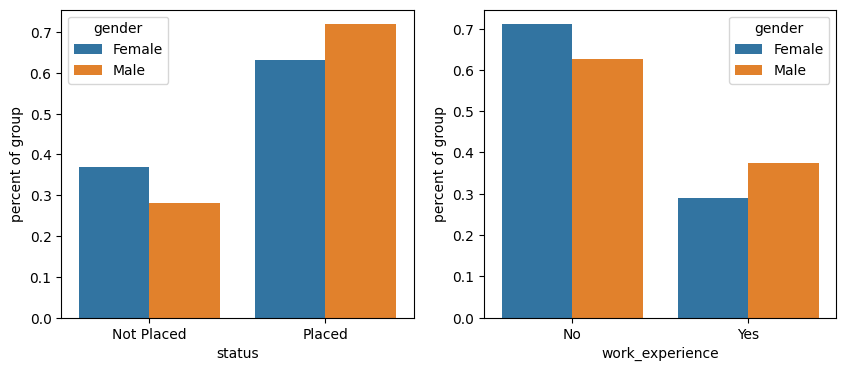

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
hist_df = data.groupby(['gender','status']).size().to_frame('count').reset_index()
hist_df.replace({'gender': {'M': 'Male', 'F': 'Female'}}, inplace=True)
hist_df['percent of group']=hist_df.groupby('gender',group_keys=False)['count'].apply(lambda x:x/x.sum())
sns.barplot(x='status', y='percent of group', hue='gender', data=hist_df, ax=axes[0])

hist_df = data.groupby(['gender','work_experience']).size().to_frame('count').reset_index()
hist_df.replace({'gender': {'M': 'Male', 'F': 'Female'}}, inplace=True)
hist_df['percent of group']=hist_df.groupby('gender',group_keys=False)['count'].apply(lambda x:x/x.sum())
sns.barplot(x='work_experience', y='percent of group', hue='gender', data=hist_df, ax=axes[1])

Text(0.5, 1.0, 'mba percentage')

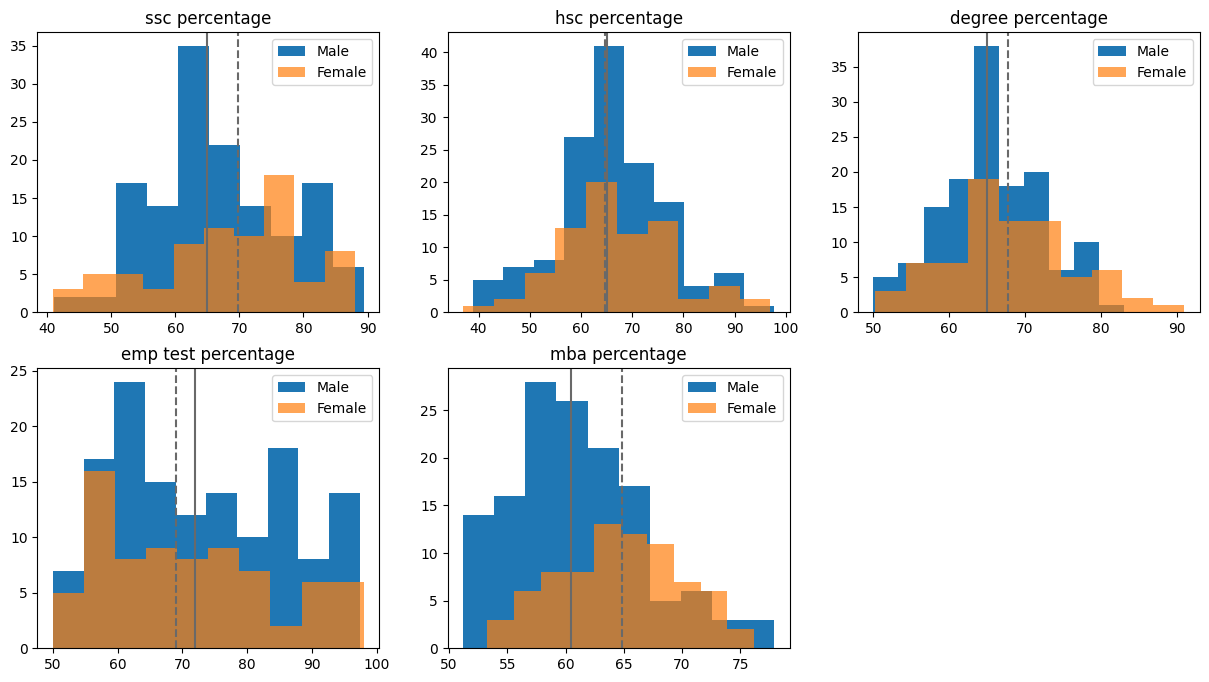

In [ ]:
# gender and test scores
fig=plt.figure(figsize=(15,8))
ssc = data['ssc_percentage'].groupby(data['gender'])
plt.subplot(231)
plt.hist(ssc.get_group('M'),label='Male')
plt.hist(ssc.get_group('F'),label='Female',alpha=0.7)
plt.axvline(x=np.median(ssc.get_group('M')), color = 'dimgray', linestyle ='-')
plt.axvline(x=np.median(ssc.get_group('F')), color = 'dimgray', linestyle ='--')
plt.legend()
plt.title('ssc percentage')


hsc = data['hsc_percentage'].groupby(data['gender'])
plt.subplot(232)
plt.hist(hsc.get_group('M'), label = 'Male')
plt.hist(hsc.get_group('F'), label = 'Female', alpha=0.7)
plt.axvline(x=np.median(hsc.get_group('M')), color = 'dimgray', linestyle ='-')
plt.axvline(x=np.median(hsc.get_group('F')), color = 'dimgray', linestyle ='--')
plt.legend()
plt.title('hsc percentage')

degree = data['degree_percentage'].groupby(data['gender'])
plt.subplot(233)
plt.hist(degree.get_group('M'), label = 'Male')
plt.hist(degree.get_group('F'), label = 'Female', alpha=0.7)
plt.axvline(x=np.median(degree.get_group('M')), color = 'dimgray', linestyle ='-')
plt.axvline(x=np.median(degree.get_group('F')), color = 'dimgray', linestyle ='--')
plt.legend()
plt.title('degree percentage')

plt.subplot(234)
emp = data['emp_test_percentage'].groupby(data['gender'])
plt.hist(emp.get_group('M'), label = 'Male')
plt.hist(emp.get_group('F'), label = 'Female', alpha=0.7)
plt.axvline(x=np.median(emp.get_group('M')), color = 'dimgray', linestyle ='-')
plt.axvline(x=np.median(emp.get_group('F')), color = 'dimgray', linestyle ='--')
plt.legend()
plt.title('emp test percentage')

plt.subplot(235)
mba = data['mba_percent'].groupby(data['gender'])
plt.hist(mba.get_group('M'), label = 'Male')
plt.hist(mba.get_group('F'), label = 'Female', alpha=0.7)
plt.axvline(x=np.median(mba.get_group('M')), color = 'dimgray', linestyle ='-')
plt.axvline(x=np.median(mba.get_group('F')), color = 'dimgray', linestyle ='--')
plt.legend()
plt.title('mba percentage')

## Implementation and validation
**Kaggle Notebook Reference: Job Placement Dataset (Shngare,Prasad)**
- Link:https://www.kaggle.com/code/prasadshingare/job-placement-dataset#Preparing-Dataset-for-ML-model

In [ ]:
# original kaggle notebook, author saves dataset as 'job'
job = data

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
job['specialisation']=le.fit_transform(job['specialisation'])
job['undergrad_degree']=le.fit_transform(job['undergrad_degree'])
job['hsc_subject']=le.fit_transform(job['hsc_subject'])
job['hsc_board']=le.fit_transform(job['hsc_board'])
job['ssc_board']=le.fit_transform(job['ssc_board'])
job['gender']=le.fit_transform(job['gender'])
job['work_experience']=le.fit_transform(job['work_experience'])

In [ ]:
X = job.drop('status',axis=1)
y = job[['status']]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score , classification_report, ConfusionMatrixDisplay,precision_score,recall_score, f1_score,roc_auc_score,roc_curve

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2,random_state=42)

**Deploying ML Models**

In [ ]:
models={
    "Logisitic Regression" :LogisticRegression(max_iter=20000),
    "Decision Tree" :DecisionTreeClassifier(),
    "Random Forest":RandomForestClassifier(),
    "Support Vector Machine": svm.SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=3),
    "Multinomial Naive Bayes": MultinomialNB()
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train,y_train.values.ravel()) # Train Model
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred =  model.predict(X_test)

  # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) 
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') 
    model_test_precision = precision_score(y_test, y_test_pred , average='weighted') 
    model_test_recall  = recall_score(y_test, y_test_pred,average='weighted') 

  # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) 
    model_train_f1 = f1_score(y_train, y_train_pred, average= 'weighted') 
    model_train_precision = precision_score(y_train, y_train_pred,average='weighted') 
    model_train_recall = recall_score(y_train, y_train_pred,average='weighted') 

    print(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:4f}'.format(model_train_f1))
    print('- Precision: {:4f}'.format(model_train_precision))
    print('- Recall: {:4f}'.format(model_train_recall))

    print('----------------------------------')

    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy) )
    print('- Fl score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))


    print('='*35)
    print('\n')

Logisitic Regression
Model performance for Training set
- Accuracy: 0.8895
- F1 score: 0.888060
- Precision: 0.888324
- Recall: 0.889535
----------------------------------
Model performance for Test set
- Accuracy: 0.8837
- Fl score: 0.8821
- Precision: 0.8817
- Recall: 0.8837


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.000000
- Precision: 1.000000
- Recall: 1.000000
----------------------------------
Model performance for Test set
- Accuracy: 0.8372
- Fl score: 0.8391
- Precision: 0.8420
- Recall: 0.8372


Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.000000
- Precision: 1.000000
- Recall: 1.000000
----------------------------------
Model performance for Test set
- Accuracy: 0.7907
- Fl score: 0.7710
- Precision: 0.7801
- Recall: 0.7907


Support Vector Machine
Model performance for Training set
- Accuracy: 0.8605
- F1 score: 0.850455
- Precision: 0.872493
- Recall: 0.860465
----------------------------------


## Outcomes

In [ ]:
# change y_train and y_test to numerical target labels
# original y_train & y_test labeled as 'Placed' and 'Not Placed'
y_train.value_counts()

status    
Placed        117
Not Placed     55
dtype: int64

In [ ]:
y_train = y_train.replace({'Placed':1, 'Not Placed':0})
y_test = y_test.replace({'Placed':1, 'Not Placed':0})

In [ ]:
y_train.value_counts()

status
1         117
0          55
dtype: int64

In [ ]:
# for interpretation of metric_frame
X_test['gender'] = X_test['gender'].replace({'M': 0, 'F':1})
X_train['gender'] = X_train['gender'].replace({'M': 0, 'F':1})


**ADS Models**

In [ ]:
lr = LogisticRegression(max_iter=20000).fit(X_train,y_train.values.ravel()) # Logistic Regression
dt = DecisionTreeClassifier().fit(X_train,y_train.values.ravel()) # Decision Tree
rf = RandomForestClassifier().fit(X_train,y_train.values.ravel()) # Random Forest
svc = svm.SVC().fit(X_train,y_train.values.ravel()) # Support Vector Machine
kn = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train.values.ravel()) # K-Nearest Neighbors
mnb = MultinomialNB().fit(X_train, y_train.values.ravel()) # Multinomial Naive Bayes

**Logistic Regression**

In [ ]:
y_pred_lr = lr.predict(X_test)

In [ ]:
metric_dict = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'false negative rate': false_negative_rate,
    'false positive rate': false_positive_rate,
    'false negative rate difference': false_negative_rate_difference,
    'false positive rate difference': false_positive_rate_difference,
    'demographic parity ratio': demographic_parity_ratio,
    'equalized odds ratio': equalized_odds_ratio,
    'selection rate difference': selection_rate_difference
    
}
sample_params = {
    'false negative rate difference': {'sensitive_features': X_test['gender']},
    'false positive rate difference': {'sensitive_features': X_test['gender']},
    'demographic parity ratio': {'sensitive_features': X_test['gender']},
    'equalized odds ratio': {'sensitive_features': X_test['gender']},
    'selection rate difference': {'sensitive_features': X_test['gender']}
}

metric_frame_lr = MetricFrame(
    metrics=metric_dict, 
    y_true=y_test,
    y_pred=y_pred_lr,
    sensitive_features=X_test['gender'],
    sample_params=sample_params
    )

In [ ]:
metric_frame_lr.overall

accuracy                          0.883721
precision                         0.906250
recall                            0.935484
false negative rate               0.064516
false positive rate               0.250000
false negative rate difference    0.065657
false positive rate difference    0.375000
demographic parity ratio          0.598465
equalized odds ratio              0.250000
selection rate difference         0.355204
dtype: float64

In [ ]:
metric_frame_1 = metric_frame_lr.by_group
metric_frame_1 = metric_frame_1[['accuracy', 'precision', 'recall','false negative rate', 'false positive rate']]
metric_frame_1

,accuracy,precision,recall,false negative rate,false positive rate
gender,,,,,
0,0.882353,0.888889,0.888889,0.111111,0.125
1,0.884615,0.913043,0.954545,0.045455,0.500


**Decision Tree**

In [ ]:
y_pred_dt = dt.predict(X_test)

In [ ]:
metric_frame_dt = MetricFrame(
    metrics=metric_dict, 
    y_true=y_test,
    y_pred=y_pred_dt,
    sensitive_features=X_test['gender'],
    sample_params=sample_params
    )

In [ ]:
metric_frame_dt.overall

accuracy                          0.837209
precision                         0.900000
recall                            0.870968
false negative rate               0.129032
false positive rate               0.250000
false negative rate difference    0.025253
false positive rate difference    0.000000
demographic parity ratio          0.764706
equalized odds ratio              0.971591
selection rate difference         0.180995
dtype: float64

In [ ]:
metric_frame_2 = metric_frame_dt.by_group
metric_frame_2 = metric_frame_2[['accuracy', 'precision', 'recall','false negative rate', 'false positive rate']]
metric_frame_2

,accuracy,precision,recall,false negative rate,false positive rate
gender,,,,,
0,0.823529,0.80,0.888889,0.111111,0.25
1,0.846154,0.95,0.863636,0.136364,0.25


**Random Forest**

In [ ]:
y_pred_rf = rf.predict(X_test)

In [ ]:
metric_frame_rf = MetricFrame(
    metrics=metric_dict, 
    y_true=y_test,
    y_pred=y_pred_rf,
    sensitive_features=X_test['gender'],
    sample_params=sample_params
    )

In [ ]:
metric_frame_rf.overall

accuracy                          0.790698
precision                         0.805556
recall                            0.935484
false negative rate               0.064516
false positive rate               0.583333
false negative rate difference    0.065657
false positive rate difference    0.250000
demographic parity ratio          0.764706
equalized odds ratio              0.666667
selection rate difference         0.217195
dtype: float64

In [ ]:
metric_frame_3 = metric_frame_rf.by_group
metric_frame_3 = metric_frame_3[['accuracy', 'precision', 'recall','false negative rate', 'false positive rate']]
metric_frame_3

,accuracy,precision,recall,false negative rate,false positive rate
gender,,,,,
0,0.705882,0.666667,0.888889,0.111111,0.50
1,0.846154,0.875000,0.954545,0.045455,0.75


**Support Vector Machine**



In [ ]:
y_pred_svc = svc.predict(X_test)

In [ ]:
metric_frame_svc = MetricFrame(
    metrics=metric_dict, 
    y_true=y_test,
    y_pred=y_pred_svc,
    sensitive_features=X_test['gender'],
    sample_params=sample_params
    )

In [ ]:
metric_frame_rf.overall

accuracy                          0.790698
precision                         0.805556
recall                            0.935484
false negative rate               0.064516
false positive rate               0.583333
false negative rate difference    0.065657
false positive rate difference    0.250000
demographic parity ratio          0.764706
equalized odds ratio              0.666667
selection rate difference         0.217195
dtype: float64

In [ ]:
metric_frame_4 = metric_frame_svc.by_group
metric_frame_4 = metric_frame_4[['accuracy', 'precision', 'recall','false negative rate', 'false positive rate']]
metric_frame_4

,accuracy,precision,recall,false negative rate,false positive rate
gender,,,,,
0,0.647059,0.615385,0.888889,0.111111,0.625
1,0.846154,0.875000,0.954545,0.045455,0.750


**K-Nearest Neighbors**

In [ ]:
y_pred_kn = kn.predict(X_test)

In [ ]:
metric_frame_kn = MetricFrame(
    metrics=metric_dict, 
    y_true=y_test,
    y_pred=y_pred_kn,
    sensitive_features=X_test['gender'],
    sample_params=sample_params
    )

In [ ]:
metric_frame_kn.overall

accuracy                          0.790698
precision                         0.805556
recall                            0.935484
false negative rate               0.064516
false positive rate               0.583333
false negative rate difference    0.090909
false positive rate difference    0.125000
demographic parity ratio          0.973262
equalized odds ratio              0.800000
selection rate difference         0.022624
dtype: float64

In [ ]:
metric_frame_5 = metric_frame_kn.by_group
metric_frame_5 = metric_frame_5[['accuracy', 'precision', 'recall','false negative rate', 'false positive rate']]
metric_frame_5

,accuracy,precision,recall,false negative rate,false positive rate
gender,,,,,
0,0.705882,0.642857,1.000000,0.000000,0.625
1,0.846154,0.909091,0.909091,0.090909,0.500


**Multinomial Naive Bayes**

In [ ]:
y_pred_mnb = mnb.predict(X_test)

In [ ]:
metric_frame_mnb = MetricFrame(
    metrics=metric_dict, 
    y_true=y_test,
    y_pred=y_pred_mnb,
    sensitive_features=X_test['gender'],
    sample_params=sample_params
    )

In [ ]:
metric_frame_mnb.overall

accuracy                          0.860465
precision                         0.857143
recall                            0.967742
false negative rate               0.032258
false positive rate               0.416667
false negative rate difference    0.045455
false positive rate difference    0.125000
demographic parity ratio          0.797954
equalized odds ratio              0.750000
selection rate difference         0.178733
dtype: float64

In [ ]:
metric_frame_6 = metric_frame_mnb.by_group
metric_frame_6 = metric_frame_6[['accuracy', 'precision', 'recall','false negative rate', 'false positive rate']]
metric_frame_6

,accuracy,precision,recall,false negative rate,false positive rate
gender,,,,,
0,0.823529,0.750000,1.000000,0.000000,0.375
1,0.884615,0.913043,0.954545,0.045455,0.500


**Metric Comparion between Models**

**Overall Comparison**

In [ ]:
models_label = ['Logistc Regression', 'Decision Tree', 'Random Forest', 'Support Vectore Machine','K-Nearest Neighbors','Multinomial Naive Bayes']
overall_label = ['Accuracy','Precision','Recall','FNR','FPR','FNR_diff','FPR_diff','DPR','EOR','SRD']

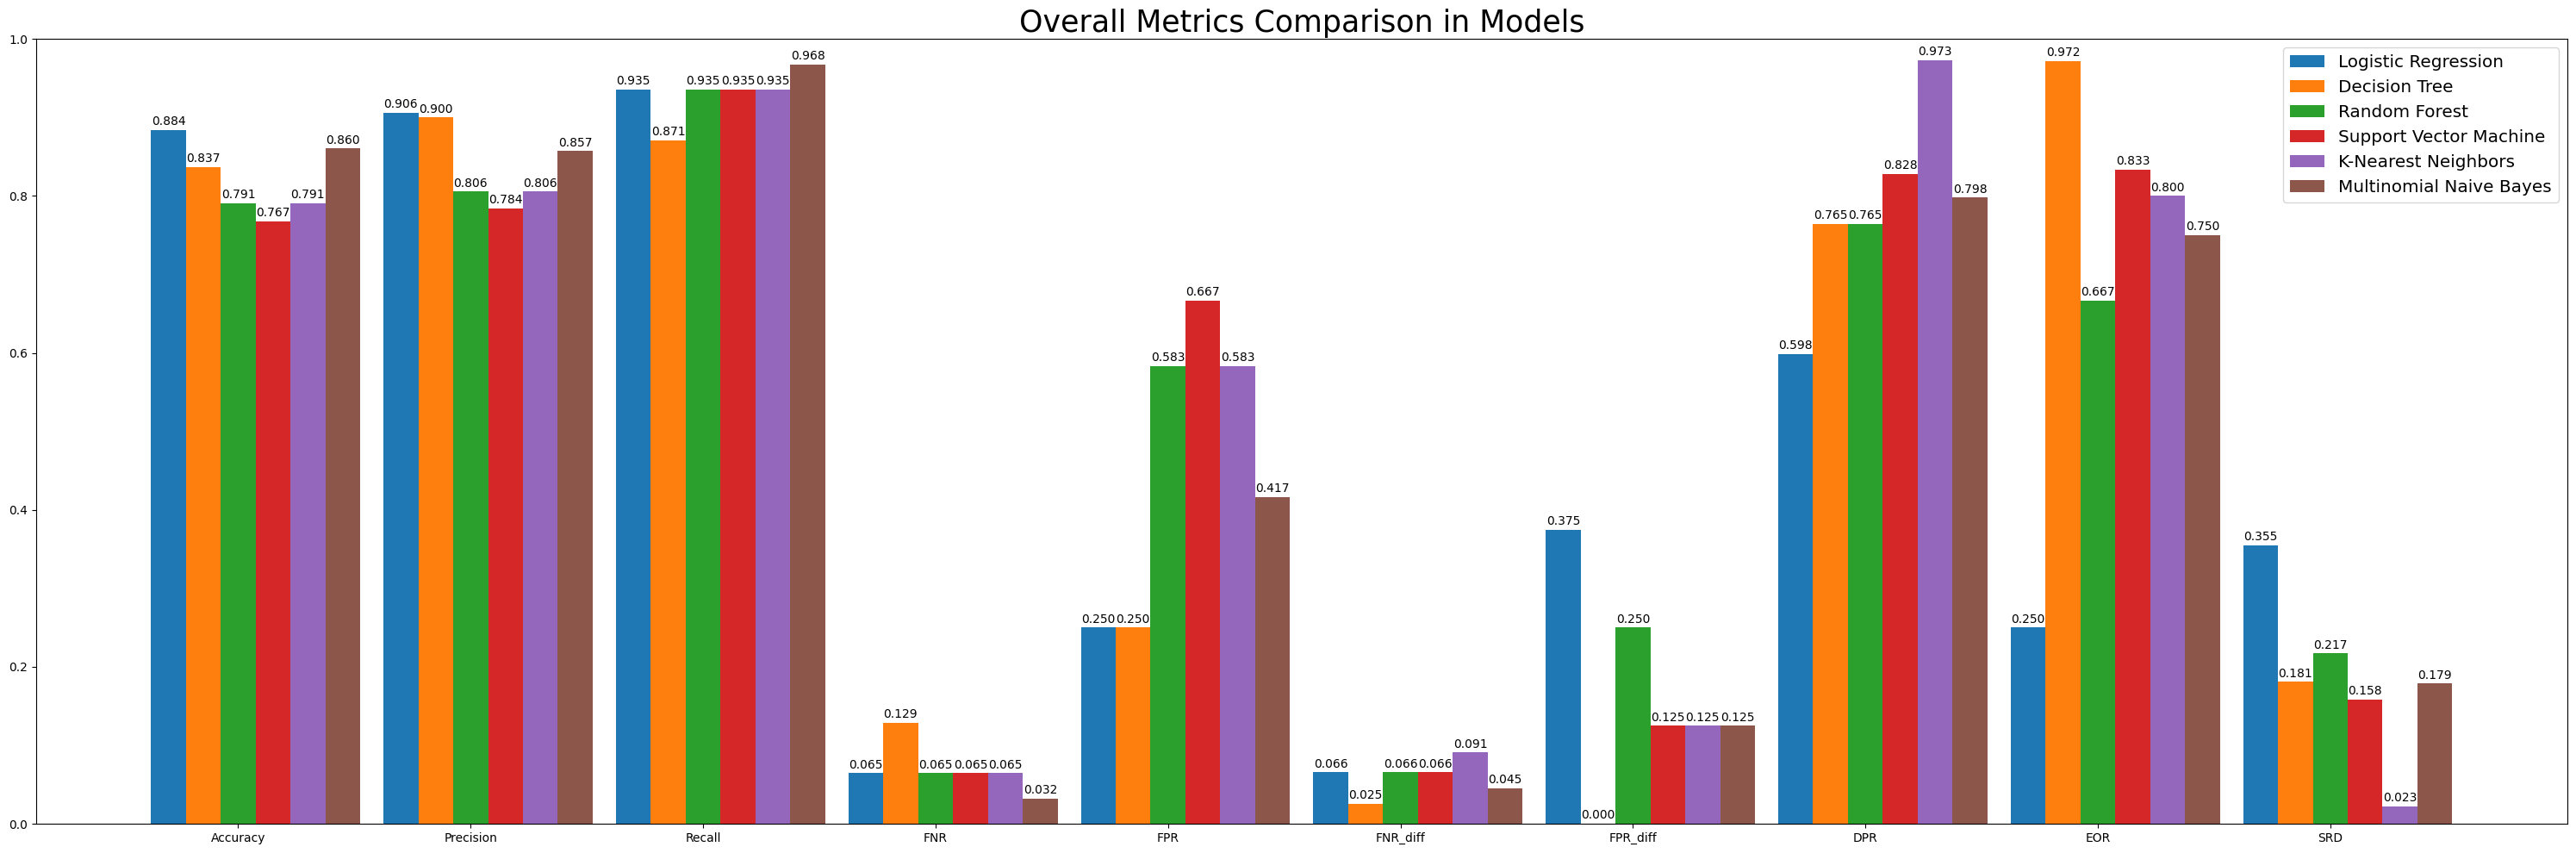

In [ ]:
x = np.arange(len(overall_label))
width = 0.15  # narrower bars

fig, ax = plt.subplots(figsize=(30, 10))
rects1 = ax.bar(x - 2*width, metric_frame_lr.overall, width, label='Logistic Regression')
rects2 = ax.bar(x - width, metric_frame_dt.overall, width, label='Decision Tree')
rects3 = ax.bar(x, metric_frame_rf.overall, width, label='Random Forest')
rects4 = ax.bar(x + width, metric_frame_svc.overall, width, label='Support Vector Machine')
rects5 = ax.bar(x + 2*width, metric_frame_kn.overall, width, label='K-Nearest Neighbors')
rects6 = ax.bar(x + 3*width, metric_frame_mnb.overall, width, label='Multinomial Naive Bayes')

ax.set_title('Overall Metrics Comparison in Models', size=25)
ax.set_xticks(x)
ax.set_xticklabels(overall_label)
ax.legend(fontsize='x-large')
ax.bar_label(rects1, padding=2, fmt='%.3f')
ax.bar_label(rects2, padding=2, fmt='%.3f')
ax.bar_label(rects3, padding=2, fmt='%.3f')
ax.bar_label(rects4, padding=2, fmt='%.3f')
ax.bar_label(rects5, padding=2, fmt='%.3f')
ax.bar_label(rects6, padding=2, fmt='%.3f')
ax.set_ylim([0, 1])
fig.tight_layout()
plt.show()


**Group Metric**

In [ ]:
Accuracy = pd.DataFrame({'Logistic Regression':metric_frame_1['accuracy'], 'Decision Tree':metric_frame_2['accuracy'], 'Random Forest': metric_frame_3['accuracy'], 'Support Vector Machine': metric_frame_4['accuracy'],'K-Nearest Neighbors':metric_frame_5['accuracy'], 'Multinomial Naive Bayes':metric_frame_6['accuracy']})
Precision = pd.DataFrame({'Logistic Regression':metric_frame_1['precision'], 'Decision Tree':metric_frame_2['precision'], 'Random Forest': metric_frame_3['precision'], 'Support Vector Machine': metric_frame_4['precision'],'K-Nearest Neighbors':metric_frame_5['precision'], 'Multinomial Naive Bayes':metric_frame_6['precision']})
Recall = pd.DataFrame({'Logistic Regression':metric_frame_1['recall'], 'Decision Tree':metric_frame_2['recall'], 'Random Forest': metric_frame_3['recall'], 'Support Vector Machine': metric_frame_4['recall'],'K-Nearest Neighbors':metric_frame_5['recall'], 'Multinomial Naive Bayes':metric_frame_6['recall']})
FNR = pd.DataFrame({'Logistic Regression':metric_frame_1['false negative rate'], 'Decision Tree':metric_frame_2['false negative rate'], 'Random Forest': metric_frame_3['false negative rate'], 'Support Vector Machine': metric_frame_4['false negative rate'],'K-Nearest Neighbors':metric_frame_5['false negative rate'], 'Multinomial Naive Bayes':metric_frame_6['false negative rate']})
FPR = pd.DataFrame({'Logistic Regression':metric_frame_1['false positive rate'], 'Decision Tree':metric_frame_2['false positive rate'], 'Random Forest': metric_frame_3['false positive rate'], 'Support Vector Machine': metric_frame_4['false positive rate'],'K-Nearest Neighbors':metric_frame_5['false positive rate'], 'Multinomial Naive Bayes':metric_frame_6['false positive rate']})

In [ ]:
group_metric =[Accuracy,Precision,Recall,FNR,FPR]
group_labels = ['Accuracy', 'Precision', 'Recall','FNR','FPR']

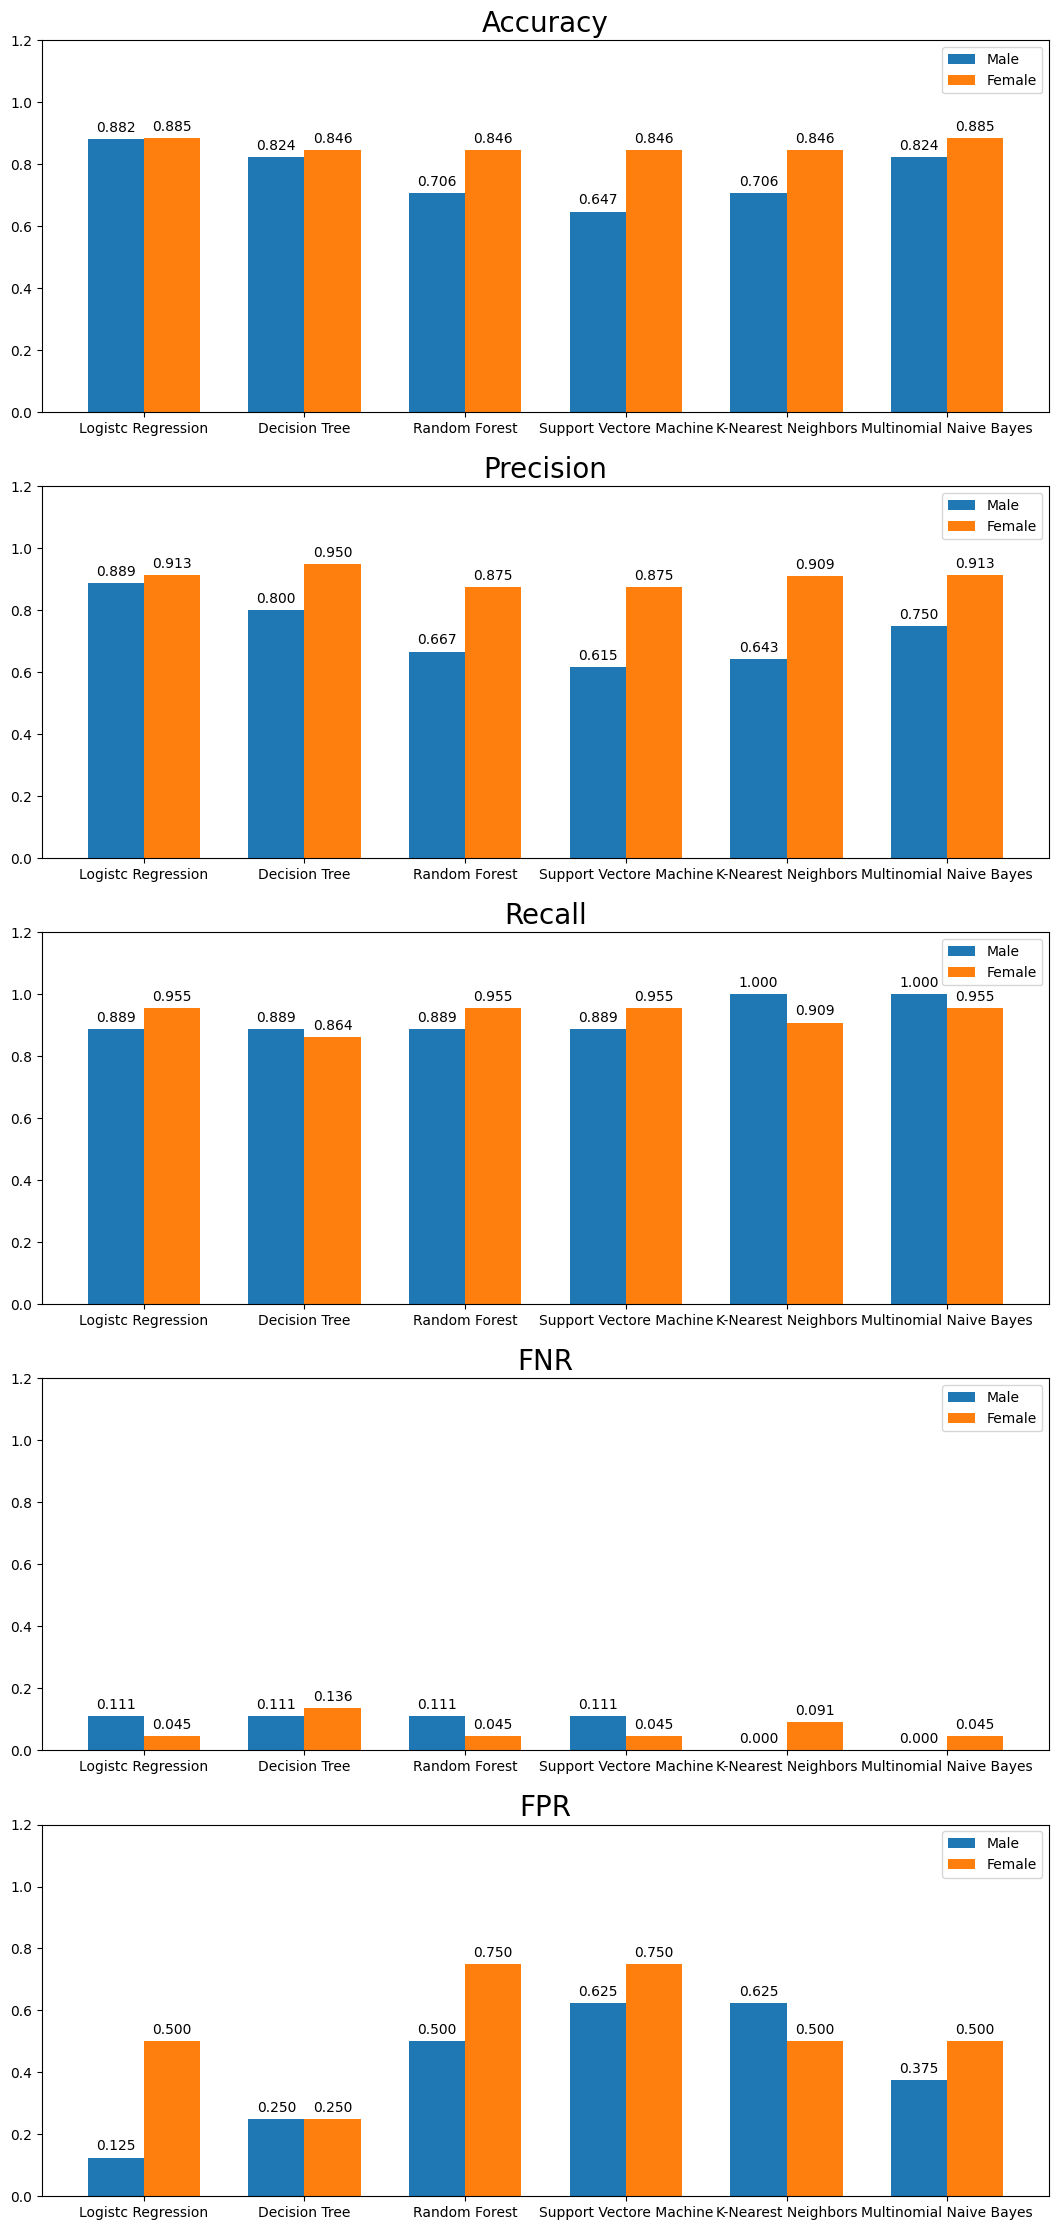

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(13, 28), dpi=100)
for i in range(5):
  x = np.arange(len(models_label))
  width = 0.35
  rects1 = axes[i].bar(x - width/2, group_metric[i].iloc[0,:], width, label='Male')
  rects2 = axes[i].bar(x + width/2, group_metric[i].iloc[1,:], width, label='Female')
  axes[i].set_title(group_labels[i], size=20)
  axes[i].set_xticks(x)
  axes[i].set_xticklabels(models_label)
  axes[i].legend()
  axes[i].bar_label(rects1, padding=3, fmt='%.3f')
  axes[i].bar_label(rects2, padding=3, fmt='%.3f')
  axes[i].set_ylim([0, 1.2])
plt.show()

**ADS Performance Evaluation**

In [ ]:
!pip install shap==0.39.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for shap: filename=shap-0.39.0-cp310-cp310-linux_x86_64.whl size=535080 sha256=772dca12cfea8a66549fc92f878f94bcee5e233faafa8bf2d54bd1f955271881
  Stored in directory: /root/.cache/pip/wheels/d4/ef/8d/78a07e01b86b1a0363626186f072e01683c10335e2eb89e337
Successfully built shap


In [ ]:
import shap

In [ ]:
# Initialize the explainer
explainer = shap.Explainer(lr, X_train)
# Apply it to the test data
shap_values = explainer.shap_values(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


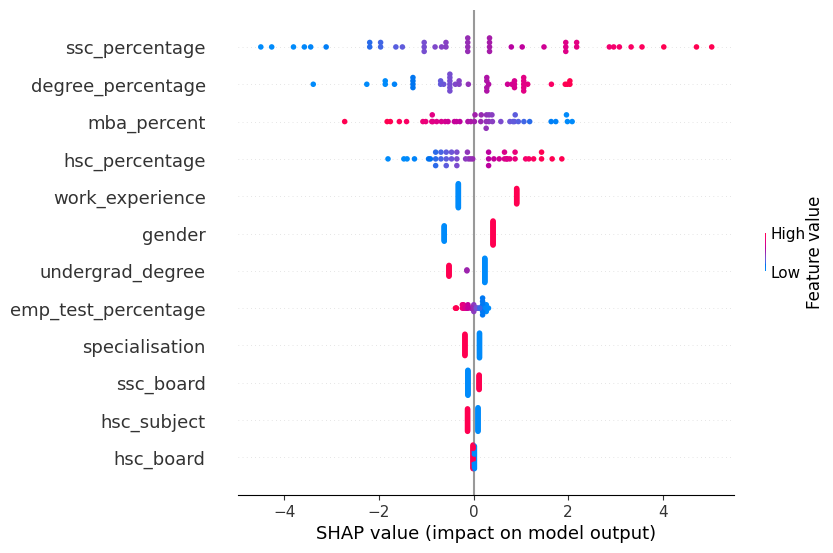

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns)

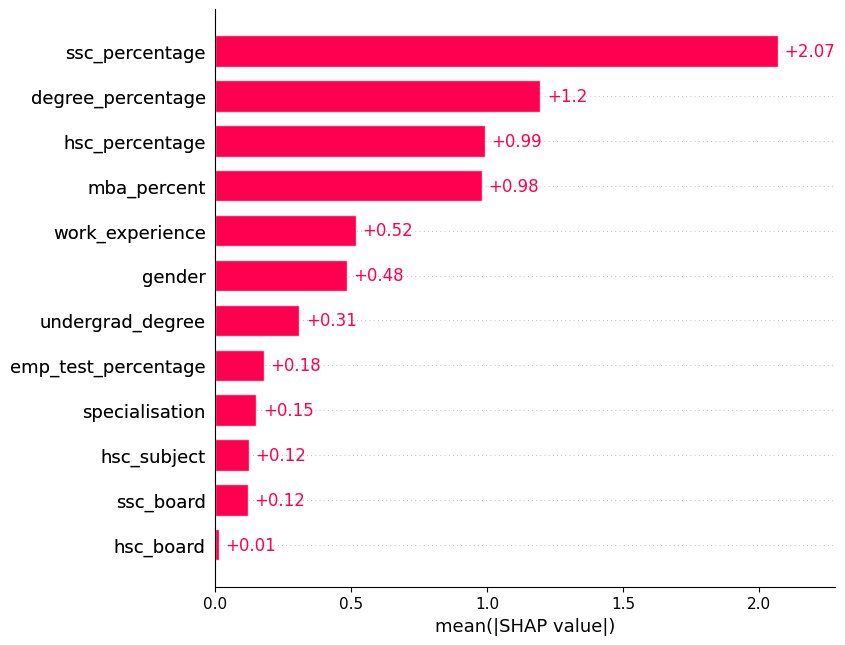

In [ ]:
shap_values = explainer(X_train)
shap.plots.bar(shap_values,max_display=13)

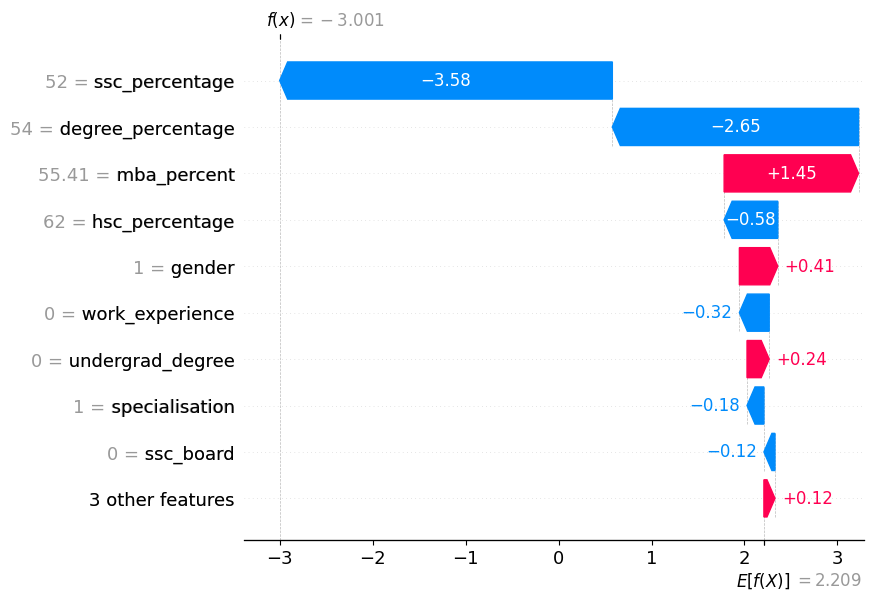

gender                  1.00
ssc_percentage         52.00
ssc_board               0.00
hsc_percentage         62.00
hsc_board               0.00
hsc_subject             1.00
degree_percentage      54.00
undergrad_degree        0.00
work_experience         0.00
emp_test_percentage    72.00
specialisation          1.00
mba_percent            55.41
Name: 93, dtype: float64
-------Actual Label-------
status    0
Name: 93, dtype: int64


In [ ]:
plt.figure(figsize=(4, 4))
shap.plots.waterfall(shap_values[0]) # For the first observation
print(X_train.iloc[0])
print('-------Actual Label-------')
print(y_train.iloc[0])

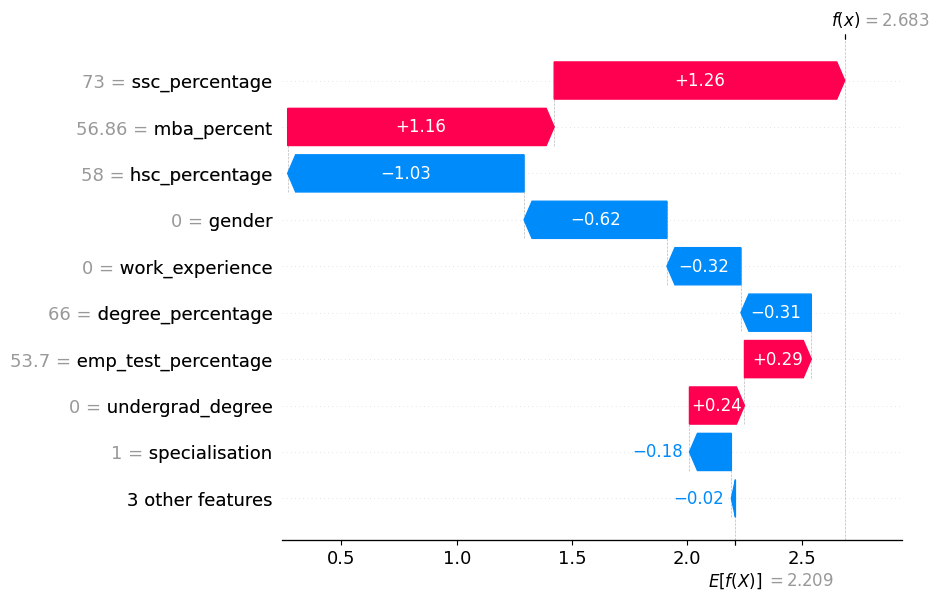

gender                  0.00
ssc_percentage         73.00
ssc_board               1.00
hsc_percentage         58.00
hsc_board               1.00
hsc_subject             2.00
degree_percentage      66.00
undergrad_degree        0.00
work_experience         0.00
emp_test_percentage    53.70
specialisation          1.00
mba_percent            56.86
Name: 38, dtype: float64
-------Actual Label-------
status    1
Name: 38, dtype: int64


In [ ]:
plt.figure(figsize=(4, 4))
shap.plots.waterfall(shap_values[8]) # For the second observation
print(X_train.iloc[8])
print('-------Actual Label-------')
print(y_train.iloc[8])


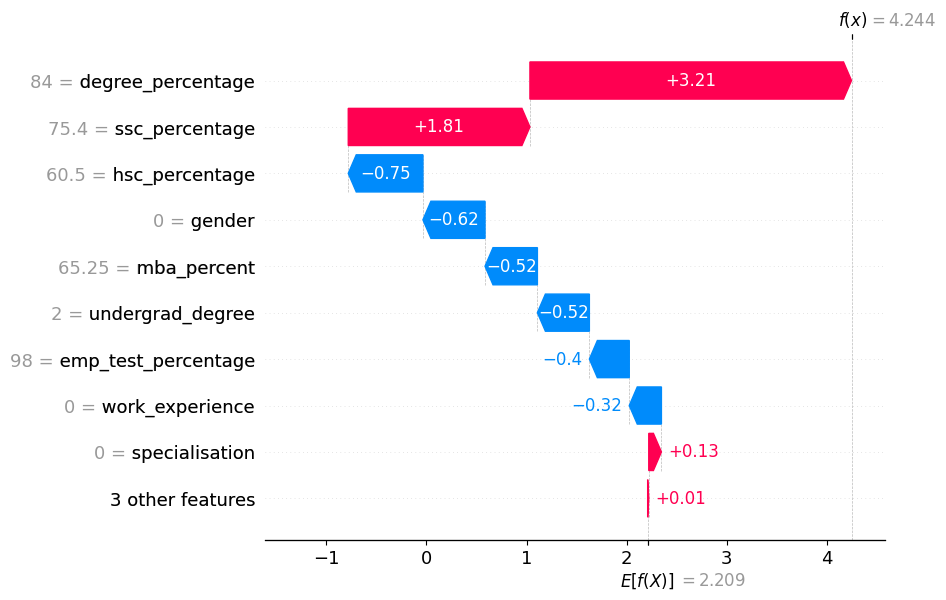

gender                  0.00
ssc_percentage         75.40
ssc_board               1.00
hsc_percentage         60.50
hsc_board               0.00
hsc_subject             2.00
degree_percentage      84.00
undergrad_degree        2.00
work_experience         0.00
emp_test_percentage    98.00
specialisation          0.00
mba_percent            65.25
Name: 152, dtype: float64
-------Actual Label-------
status    1
Name: 152, dtype: int64


In [ ]:
plt.figure(figsize=(4, 4))
shap.plots.waterfall(shap_values[7]) # For the first observation
print(X_train.iloc[7])
print('-------Actual Label-------')
print(y_train.iloc[7])